# Image classification

## Пример 1

Список моделей-трансформеров, способных решать задачу классификации, представлен на Hugging Face. Вот некоторые из них:

* Vision Transformer (ViT), ViT Hybrid, ViTMSN, LeViT
* Data-efficient image transformer (DeiT)
* BERT Pre-Training of Image Transformers (BeiT)
* Convolutional Vision Transformer (CvT)

In [1]:
%pip install transformers datasets evaluate

  Using cached datasets-2.19.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-2.19.0-py3-none-any.whl (542 kB)
Note: you may need to restart the kernel to use updated packages.


### Загрузка и предобработка данных

Загружаем для примера датасет со 101 классом, содержащий 101000 изображений (это заняло примерно 17 минут).

In [1]:
from datasets import load_dataset
food = load_dataset("food101", split="train[:5000]")

In [2]:
food = food.train_test_split(test_size=0.2) # разделяем выборку
food["train"][0] # смотрим на пример

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 6}

In [3]:
# создаем словари, в которых сопоставляем каждому названию класса свой номер
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [4]:
# занимаемся предобработкой
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k" # название модели
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

2024-04-25 14:20:37.873817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 14:20:37.899141: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 14:20:38.332143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from PIL import Image

In [6]:
# мы можем совершенно свободно применять инструменты PyTorch или TensorFlow для
# предобработки (кому что удобнее).
size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

food["train"].set_transform(preprocess_train)
food["test"].set_transform(preprocess_val)

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

2024-04-25 14:22:54.252441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 14:22:54.253281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 14:22:54.253375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Обучение и тестирование

In [8]:
%pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 kB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [9]:
import evaluate
import numpy as np
from transformers import create_optimizer
from transformers import TFAutoModelForImageClassification

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

In [10]:
accuracy = evaluate.load("accuracy")

In [11]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [12]:
batch_size = 16
num_epochs = 5
num_train_steps = len(food["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [13]:
model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# конвертирование датасетов в датасеты tensorflow

tf_train_dataset = food["train"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

tf_eval_dataset = food["test"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [15]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

### Можно запустить модель на GPU

In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs)

Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-04-25 14:24:49.650221: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


250/250 [==============================] - 121s 396ms/step - loss: 2.7621 - val_loss: 1.6041
Epoch 2/5
250/250 [==============================] - 96s 385ms/step - loss: 1.2068 - val_loss: 0.7725
Epoch 3/5
250/250 [==============================] - 96s 384ms/step - loss: 0.6966 - val_loss: 0.4960
Epoch 4/5
250/250 [==============================] - 96s 385ms/step - loss: 0.4845 - val_loss: 0.3592
Epoch 5/5
250/250 [==============================] - 96s 384ms/step - loss: 0.3870 - val_loss: 0.3382


In [18]:
# сохраняем веса
model.save_pretrained("vit-classification")

In [19]:
# загружаем веса
model = TFAutoModelForImageClassification.from_pretrained("vit-classification",
                                                          id2label=id2label,
                                                          label2id=label2id)

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at vit-classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


## Пример 2

(через PyTorch)

In [2]:
!pip install matplotlib numpy transformers scikit-learn seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [3]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import PIL
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from transformers import DeiTFeatureExtractor

from sklearn.model_selection import train_test_split

import torch
from tqdm.auto import tqdm
from transformers import DeiTForImageClassification, AdamW, get_scheduler

import seaborn as sns

2024-04-25 16:14:16.370182: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 16:14:16.395673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 16:14:16.776233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# путь к датасету, в которой объекты разных классов распределены по папкам
data_dir = 'norm/'

Каждое изображение должно быть обработано с помощью FeatureExtractor'а для DeiT

In [5]:
classes = os.listdir(data_dir)
feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")
imgs = []
lbls = []
cnt = 0
for cl in classes:
    class_path = data_dir + '/' + cl
    images = os.listdir(class_path)
    for image in images:
        try:
            input = PIL.Image.open(class_path + '/' + image)
            input = input.convert('RGB')
            imgs.append(feature_extractor(input, return_tensors="pt")['pixel_values'][0])
            lbls.append(int(cl[1]))
        except:
            cnt += 1

print("Количество некорректно считанных изображений: ", cnt)

/home/student1/miniconda3/envs/conda-env/lib/python3.9/site-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


Количество некорректно считанных изображений:  0


Разбиение на train/test и создание PyTorch-классов для датасетов

In [6]:
train_images, val_images, train_labels, val_labels = train_test_split(imgs, lbls, test_size=.2, stratify=lbls)

In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {}
        item['inputs'] = self.images[idx]
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [8]:
train_data = ImageDataset(train_images, train_labels)
val_data = ImageDataset(val_images, val_labels)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True)

Инициализация модели

In [9]:
# инициализируем устройство, на котором модель будет обучаться
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

# num_labels - количество классов изображений
classes_amount = 3
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224",
                                                  num_labels=classes_amount,
                                                  ignore_mismatched_sizes=True)

Running on the GPU


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Гиперпараметры

In [10]:
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epoch = 20

Обучение модели

In [11]:
model.to(device)
model.train()

losses_for_train = []
losses_for_val = []
num_training_steps = num_epoch * len(train_loader)
lr_scheduler = get_scheduler('linear',
                             optimizer=optim,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

for epoch in range(num_epoch):
    loop = tqdm(train_loader, leave=True)
    model.train()
    for batch in loop:
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(inputs, labels=labels)
        loss = outputs[0]
        loss.backward()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
        optim.step()
        losses_for_train.append(loss.item())
        lr_scheduler.step()
        optim.zero_grad()
    model.eval()

    for batch in val_loader:
        inputs = batch['inputs'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(inputs, labels=labels)
        loss = outputs[0]
        losses_for_val.append(loss.item())

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Сохранение весов

In [12]:
model.save_pretrained(f'deit-v1.0_{num_epoch}')

Можно подгрузить уже имеющиеся веса модели

In [13]:
model = DeiTForImageClassification.from_pretrained("deit-v1.0_20/", num_labels=3, ignore_mismatched_sizes=True)
model.to(device)

DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in

In [14]:
# формируем список предсказаний
all_predictions = []
for batch in val_loader:
    inputs = batch['inputs'].to(device)
    with torch.no_grad():
        outputs = model(inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim= -1)
    all_predictions.extend(predictions.cpu().numpy())

get_res = {0: "Class 1", 1: "Class 2", 2: "Class 3"}

In [15]:
all_predictions = []
all_references = []
for batch in val_loader:
    inputs = batch['inputs'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=labels)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim= -1)
    all_predictions.extend(predictions.cpu().numpy())
    all_references.extend(batch['labels'].cpu().numpy())

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score

print(confusion_matrix(all_predictions, all_references))
print('accuracy:{}'.format(accuracy_score(all_predictions, all_references)))
print('precision:{}'.format(precision_score(all_predictions, all_references ,average='weighted')))
print('recall:{}'.format(recall_score(all_predictions, all_references, average='weighted')))
print('f1-score:{}'.format(f1_score(all_predictions, all_references, average='weighted')))

[[86  0  0]
 [ 0 86  0]
 [ 0  0 85]]
accuracy:1.0
precision:1.0
recall:1.0
f1-score:1.0


In [17]:
def build_conf_matrix(labels, predict, class_name):
    lab, pred = [], []
    for i in range(len(labels)):
        if predict[i] == class_name:
            pred.append(0)
        else:
            pred.append(1)
        if labels[i] == class_name:
            lab.append(0)
        else:
            lab.append(1)
    return confusion_matrix(lab, pred, normalize='true')

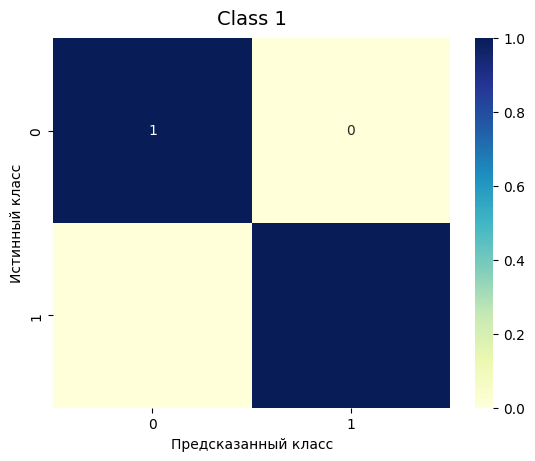

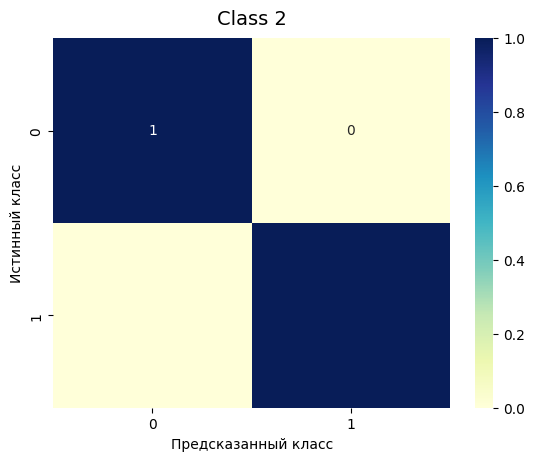

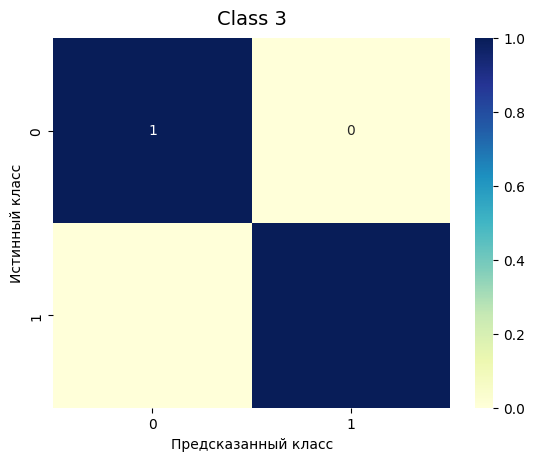

In [18]:
for i in range(classes_amount):
    heatmap = sns.heatmap(build_conf_matrix(all_predictions, all_references, i), annot=True, cmap='YlGnBu')
    heatmap.set_title(get_res[i], fontdict={'fontsize':14}, pad=10)
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.savefig(f"C{i}.png", dpi=300)
    plt.show()